# 1. Initializing the bucket and Sagemaker Session

In [1]:
import re
import boto3
import sagemaker
from sagemaker import get_execution_role
sess = sagemaker.Session()
region = boto3.Session().region_name
downloaded_data_bucket = f"myawsbucket-project2"
downloaded_data_prefix = "datasets"
bucket = sess.default_bucket()
prefix = "sagemaker/myawsbucket-project2"
role = get_execution_role()

# 2. Importing the necessary Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import time

import warnings
import os
import random
%matplotlib inline
random.seed(42)
plt.rcParams.update({'font.size': 25})
sns.set_theme(color_codes=True)
warnings.filterwarnings('ignore')

# 3. Loading the Dataset

In [3]:
train_df = pd.read_csv("s3://myawsbucket-project2/dataset/Train.csv")
test_df = pd.read_csv("s3://myawsbucket-project2/dataset/Test.csv")

In [4]:
train_df.head()

,Unnamed: 0,acc_max,gyro_max,acc_kurtosis,gyro_kurtosis,label,lin_max,acc_skewness,gyro_skewness,post_gyro_max,post_lin_max,fall
0,661,26.039919,7.309797,20.378162,2.782476,SDL,11.131080,3.891361,1.592927,7.086618,10.790400,1
1,122,25.864500,6.511954,14.187190,5.324864,FOL,7.945561,3.022175,2.376939,6.325522,7.719352,1
2,113,27.524501,12.944099,31.855926,22.891186,FOL,14.454818,4.849024,4.283890,12.888111,14.368784,1
3,14,30.647705,11.694868,23.608764,9.287735,FOL,15.228303,3.921537,2.794609,11.549971,14.944151,1
4,529,26.373917,11.168424,14.318453,15.983202,FKL,10.007396,3.087975,3.363557,11.057636,9.753058,1


In [5]:
test_df.head()

,Unnamed: 0,acc_max,gyro_max,acc_kurtosis,gyro_kurtosis,label,lin_max,acc_skewness,gyro_skewness,post_gyro_max,post_lin_max,fall
0,9,28.055199,10.794617,21.334536,34.163811,FOL,13.880578,3.283404,4.577283,10.755339,13.762561,1
1,11,26.639681,8.785024,13.518671,12.812894,FOL,15.789372,3.301849,3.464729,8.277714,15.341656,1
2,19,25.045219,5.307413,21.603060,4.754182,FOL,11.592445,3.124714,2.268676,4.976134,11.303823,1
3,23,24.102184,8.929061,24.647657,18.595684,FOL,10.107835,4.522305,3.955288,8.719755,9.727437,1
4,28,31.668808,10.714750,18.008912,15.086251,FOL,14.138265,3.142132,3.530621,10.580791,13.935016,1


In [6]:
train_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
test_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [7]:
print(f"Training data shape: {train_df.shape}\nTest data shape: {test_df.shape}")

Training data shape: (1428, 11)
Test data shape: (356, 11)


In [8]:
X_train = train_df.drop(['fall','label'],axis=1)
y_train = train_df['fall']
X_test =  test_df.drop(['fall','label'],axis=1)
y_test =  test_df['fall']

# 4. Feature Selection


Mutual Information scores

In [9]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, discrete_features=False)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train, y_train)

Plotting Mutual Information Score

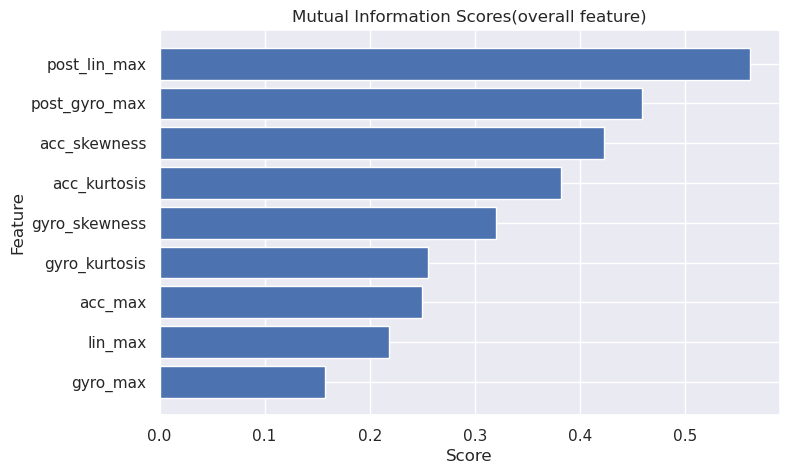

In [10]:
def plot_utility_scores(scores):
    y = scores.sort_values(ascending=True)
    width = np.arange(len(y))
    ticks = list(y.index)
    plt.barh(width, y)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores(overall feature)")

plt.figure(dpi=100, figsize=(8, 5))
plt.xlabel("Score")
plt.ylabel("Feature")
plot_utility_scores(mi_scores)

Heatmap for correlation of features

<Axes: >

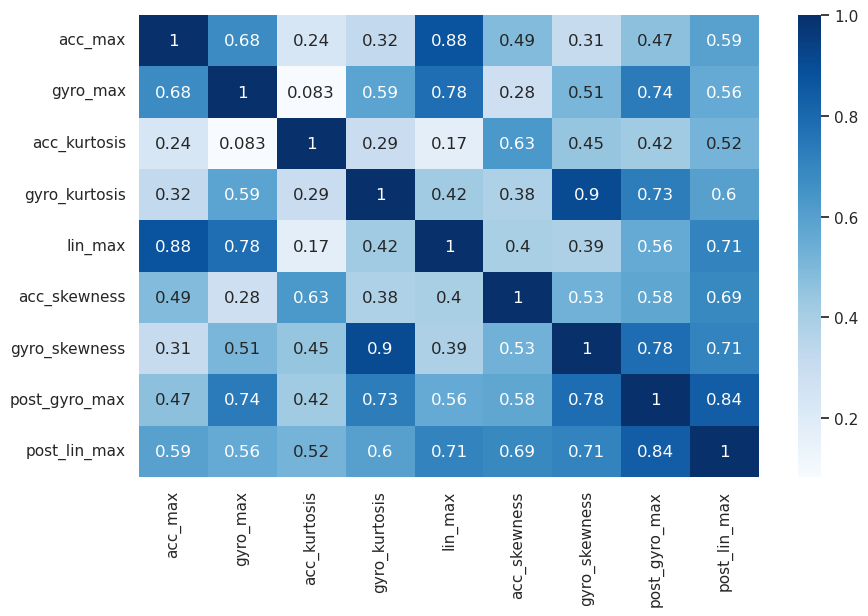

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(train_df.select_dtypes('float').corr(), ax=ax,  cmap="Blues", annot=True)

Dropping gyro_max

In [12]:
X_train.drop(['gyro_max'], axis=1, inplace=True)
X_test.drop(['gyro_max'], axis=1, inplace=True)

Plotting post_lin_max and post_gyro_max 

<Axes: xlabel='label', ylabel='post_gyro_max'>

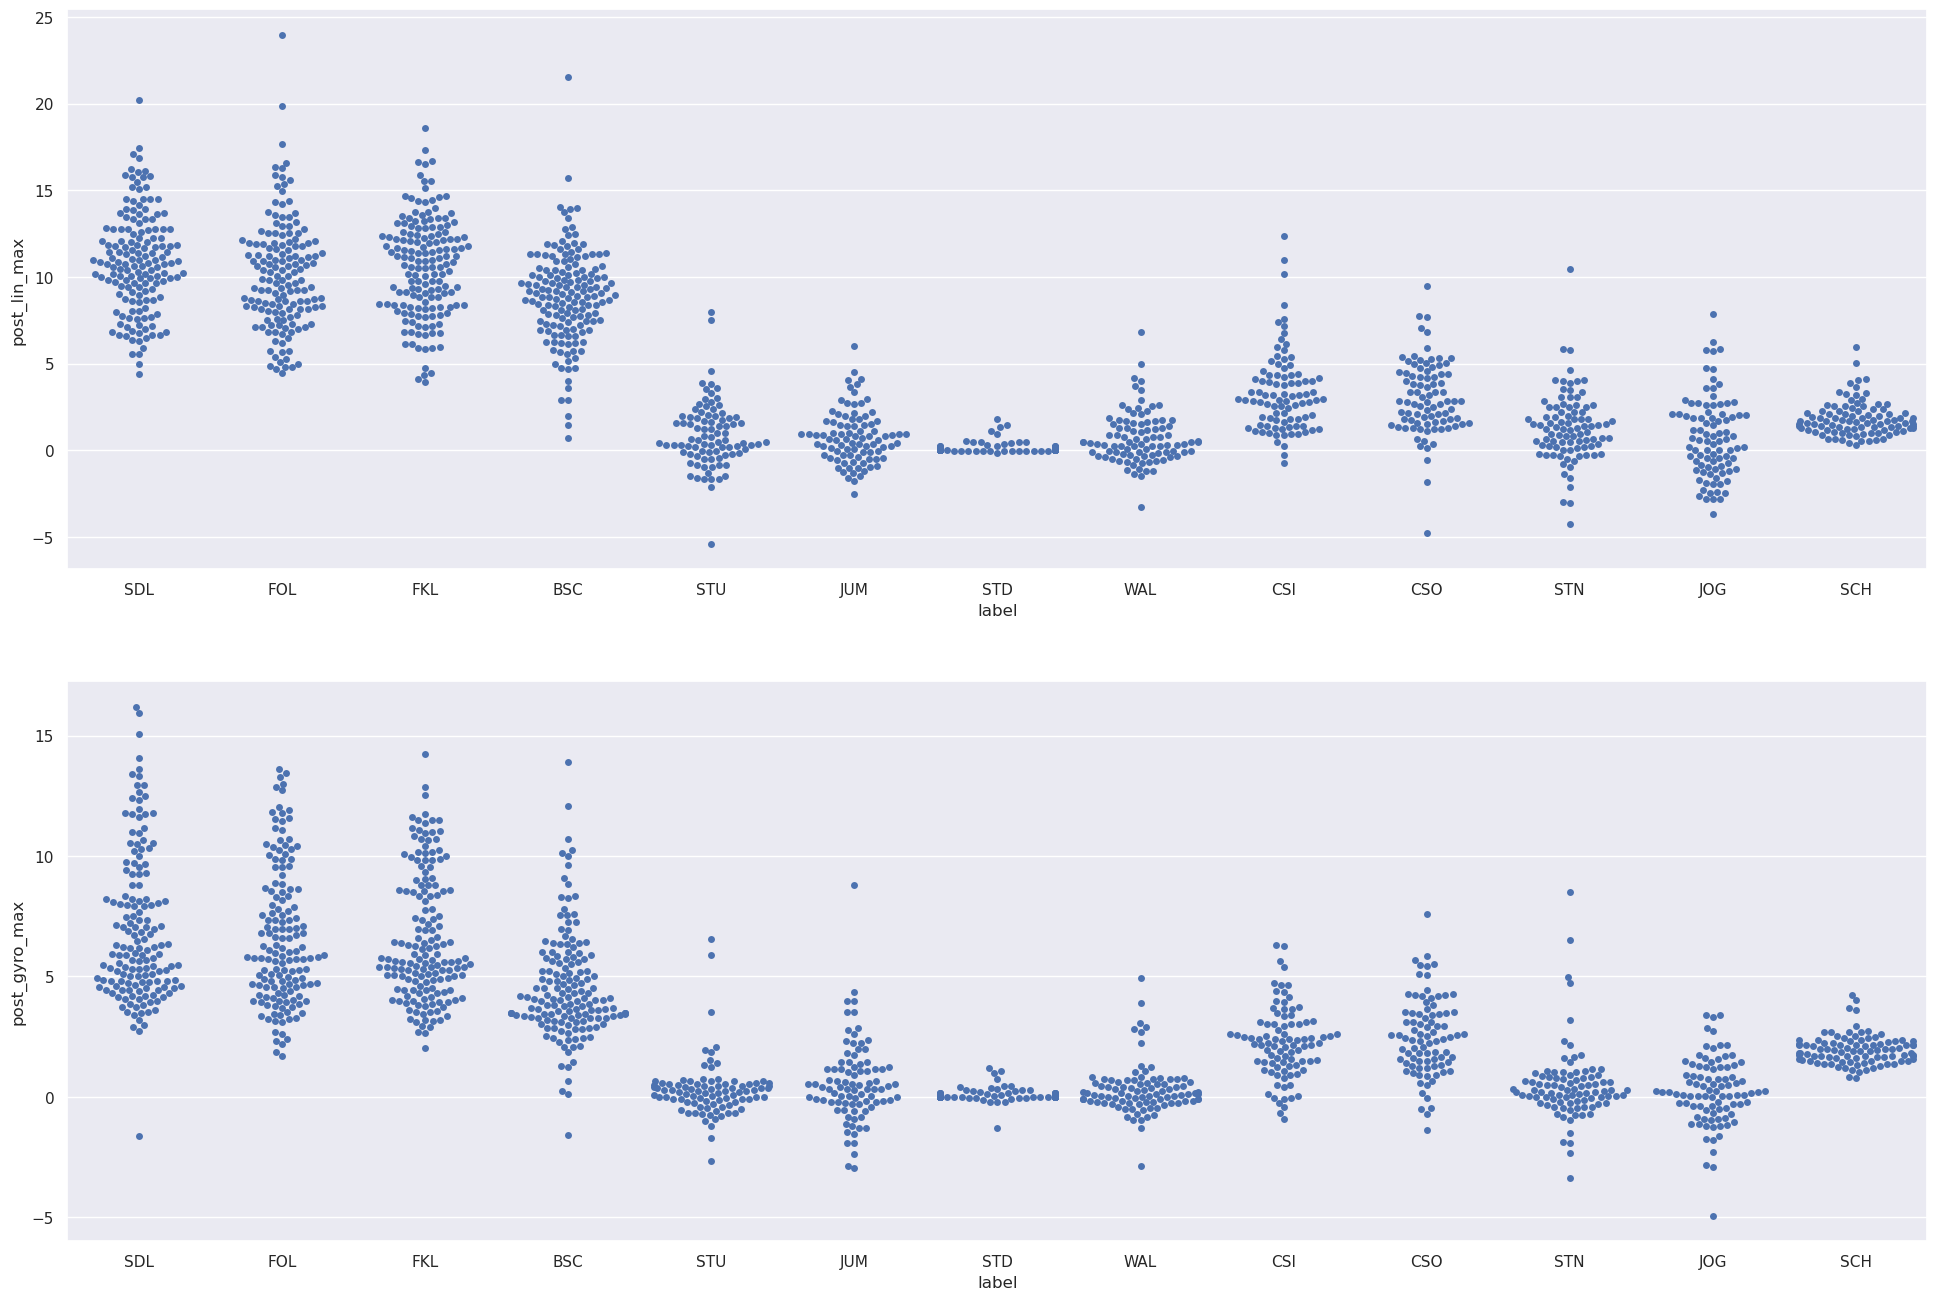

In [13]:
figure, ax = plt.subplots(2, figsize=(24, 16))

sns.swarmplot(x = train_df.label,y = train_df.post_lin_max, ax = ax[0])
sns.swarmplot(x = train_df.label,y = train_df.post_gyro_max, ax = ax[1])

# 5. Feature Normalization

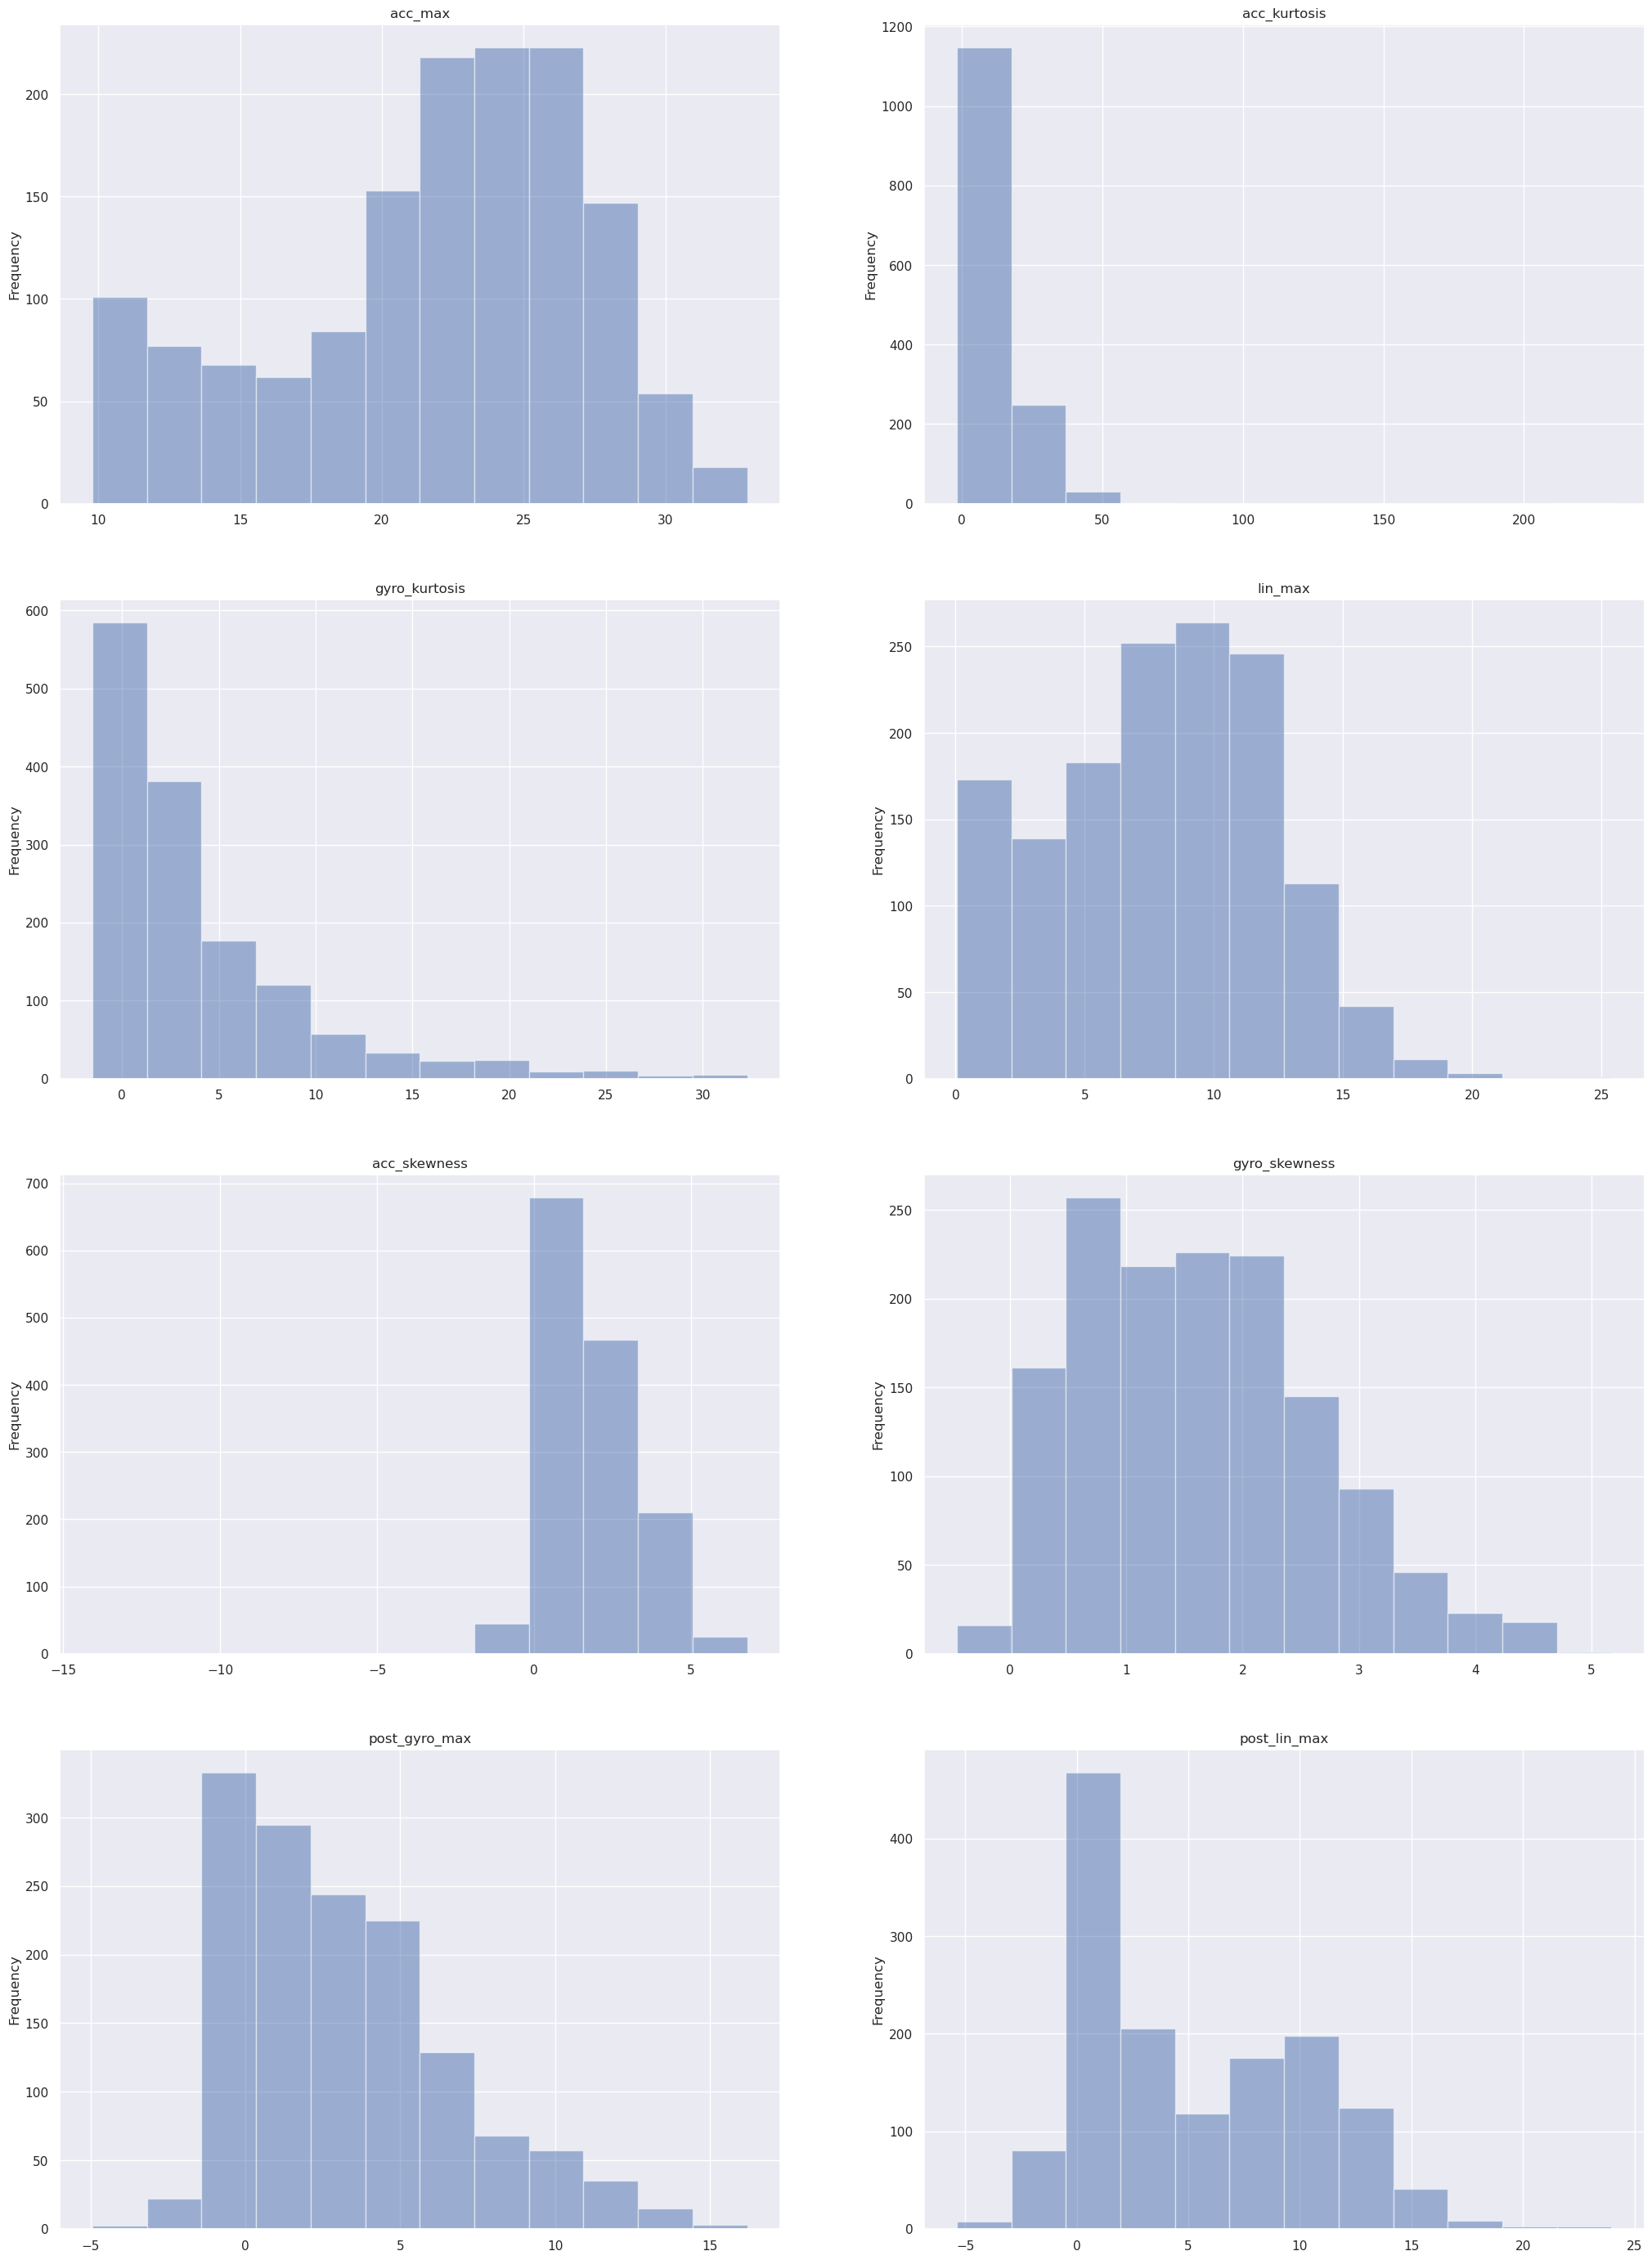

In [14]:
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
figure, ax = plt.subplots(4,2, figsize=(25, 35))
i=0
j=0
for col in X_train.columns:
    ax[j][i].title.set_text(col)
    X_train[col].plot.hist(bins=12, alpha=0.5, ax = ax[j][i])
    i+=1
    if(i%2==0):
        j+=1
        i =0

Normalization using Standard Scalar

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 6. Using Different models

In [16]:
accuracy_train = []
accuracy_test = []
cross_validation = []
time_regular = []
time_train=[]

accuracy_train_PCA = []
accuracy_test_PCA = []
cross_validation_PCA = []
time_PCA = []
time_train_PCA = []

Principal component analysis

In [17]:
pca = PCA(0.99)
pca.fit(X_train)
X_reduced  = pca.transform(X_train)
print(X_reduced.shape)
X_test_reduced = pca.transform(X_test)
print(X_test_reduced.shape)

(1428, 7)
(356, 7)


Generalized Function for training and testing all the Models

In [18]:
def train_test_model(model, modelName):

  print("==========================")
  print("Before PCA for ",modelName)
  print("==========================")

  cv_scores = cross_val_score(model, X_train, y_train, cv=5)
  print("CV Score: ",np.mean(cv_scores))
  model.fit(X_train, y_train)
  start_time = time.time() 
  print("Train accuracy: ", model.score(X_train, y_train))
  print("Time Taken to Train is %s seconds " % (time.time() - start_time))
  time_train.append(time.time() - start_time)
  start_time = time.time() 
  print("Test accuracy:  ", model.score(X_test, y_test))
  time_regular.append(time.time() - start_time)
  print("Time Taken to Test is %s seconds " % (time.time() - start_time))
  print(classification_report(y_test, model.predict(X_test),digits=5))
  accuracy_train.append(model.score(X_train, y_train))
  accuracy_test.append(model.score(X_test, y_test))
  cross_validation.append(np.mean(cv_scores))
  print('\n\n')
  print("=========================")
  print("After PCA for ",modelName)
  print("=========================")

  cv_scores = cross_val_score(model, X_reduced, y_train, cv=5)
  print("CV Score: ", np.mean(cv_scores))
  model.fit(X_reduced, y_train)
  start_time = time.time() 
  print("Train accuracy: ", model.score(X_reduced, y_train))
  time_train_PCA.append(time.time() - start_time)
  print("Time Taken to Train is %s seconds " % (time.time() - start_time))
  start_time = time.time() 
  print("Test accuracy:  ", model.score(X_test_reduced, y_test))
  time_PCA.append(time.time() - start_time)
  print("Time Taken to Test is %s seconds " % (time.time() - start_time))

  accuracy_train_PCA.append(model.score(X_reduced, y_train))
  accuracy_test_PCA.append(model.score(X_test_reduced, y_test))
  cross_validation_PCA.append(np.mean(cv_scores))

### KNN

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import operator
k_param = {}
for k in range(1, 20, 2):
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=5)
    k_param[k] = np.mean(cv_scores)
bestK = max(k_param.items(), key=operator.itemgetter(1))[0]

print('Best k: ', bestK)
print(k_param)

Best k:  15
{1: 0.9733897681266102, 3: 0.9782897803950436, 5: 0.9775904796957429, 7: 0.9754901239111765, 9: 0.9768936326831064, 11: 0.977592933382407, 13: 0.978294687768372, 15: 0.9789964421543369, 17: 0.9789939884676727, 19: 0.9775953870690713}


In [20]:
from sklearn.model_selection import GridSearchCV#create new a knn model
knn2 = KNeighborsClassifier()#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 15)}#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)#fit model to data
knn_gscv.fit(X_train, y_train)
print(knn_gscv.best_params_)

{'n_neighbors': 14}


In [21]:
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors = bestK)
train_test_model(knn, "KNN")

Before PCA for  KNN
CV Score:  0.9789964421543369
Train accuracy:  0.9789915966386554
Time Taken to Train is 0.057066917419433594 seconds 
Test accuracy:   0.9747191011235955
Time Taken to Test is 0.015450716018676758 seconds 
              precision    recall  f1-score   support

           0    0.99490   0.96059   0.97744       203
           1    0.95000   0.99346   0.97125       153

    accuracy                        0.97472       356
   macro avg    0.97245   0.97703   0.97434       356
weighted avg    0.97560   0.97472   0.97478       356




After PCA for  KNN
CV Score:  0.9789964421543369
Train accuracy:  0.9789915966386554
Time Taken to Train is 0.05511641502380371 seconds 
Test accuracy:   0.9747191011235955
Time Taken to Test is 0.015035152435302734 seconds 


### Linear discriminant analysis

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
lda = LinearDiscriminantAnalysis()
train_test_model(lda,"LDA")

Before PCA for  LDA
CV Score:  0.9726978284873022
Train accuracy:  0.9733893557422969
Time Taken to Train is 0.0008699893951416016 seconds 
Test accuracy:   0.9662921348314607
Time Taken to Test is 0.0007870197296142578 seconds 
              precision    recall  f1-score   support

           0    0.97990   0.96059   0.97015       203
           1    0.94904   0.97386   0.96129       153

    accuracy                        0.96629       356
   macro avg    0.96447   0.96722   0.96572       356
weighted avg    0.96664   0.96629   0.96634       356




After PCA for  LDA
CV Score:  0.9698883572567784
Train accuracy:  0.9712885154061625
Time Taken to Train is 0.06461238861083984 seconds 
Test accuracy:   0.9606741573033708
Time Taken to Test is 0.0009133815765380859 seconds 


### Quadratic discriminant analysis

In [23]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
train_test_model(qda,"QDA")

Before PCA for  QDA
CV Score:  0.9670960618329039
Train accuracy:  0.9712885154061625
Time Taken to Train is 0.0012378692626953125 seconds 
Test accuracy:   0.9691011235955056
Time Taken to Test is 0.057641029357910156 seconds 
              precision    recall  f1-score   support

           0    0.98000   0.96552   0.97270       203
           1    0.95513   0.97386   0.96440       153

    accuracy                        0.96910       356
   macro avg    0.96756   0.96969   0.96855       356
weighted avg    0.96931   0.96910   0.96914       356




After PCA for  QDA
CV Score:  0.9692037786774629
Train accuracy:  0.9712885154061625
Time Taken to Train is 0.028032779693603516 seconds 
Test accuracy:   0.9691011235955056
Time Taken to Test is 0.0009815692901611328 seconds 


### Support Vector Machine

In [24]:
from sklearn.svm import SVC
svc = SVC(kernel='poly', degree=2, gamma='auto')
train_test_model(svc, "SVC")

Before PCA for  SVC
CV Score:  0.8984639921482026
Train accuracy:  0.9089635854341737
Time Taken to Train is 0.03165864944458008 seconds 
Test accuracy:   0.9073033707865169
Time Taken to Test is 0.00885772705078125 seconds 
              precision    recall  f1-score   support

           0    0.91667   0.92118   0.91892       203
           1    0.89474   0.88889   0.89180       153

    accuracy                        0.90730       356
   macro avg    0.90570   0.90504   0.90536       356
weighted avg    0.90724   0.90730   0.90727       356




After PCA for  SVC
CV Score:  0.8956643356643357
Train accuracy:  0.9005602240896359
Time Taken to Train is 0.03209066390991211 seconds 
Test accuracy:   0.8960674157303371
Time Taken to Test is 0.008585691452026367 seconds 


### Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
clf_random = RandomForestClassifier(n_estimators=64, max_depth=5, random_state=0)
train_test_model(clf_random, "Random Forest")

Before PCA for  Random Forest
CV Score:  0.9768960863697705
Train accuracy:  0.9908963585434174
Time Taken to Train is 0.015155553817749023 seconds 
Test accuracy:   0.9747191011235955
Time Taken to Test is 0.010335922241210938 seconds 
              precision    recall  f1-score   support

           0    0.98990   0.96552   0.97756       203
           1    0.95570   0.98693   0.97106       153

    accuracy                        0.97472       356
   macro avg    0.97280   0.97622   0.97431       356
weighted avg    0.97520   0.97472   0.97476       356




After PCA for  Random Forest
CV Score:  0.9761943319838057
Train accuracy:  0.9845938375350141
Time Taken to Train is 0.015533447265625 seconds 
Test accuracy:   0.9831460674157303
Time Taken to Test is 0.010245561599731445 seconds 


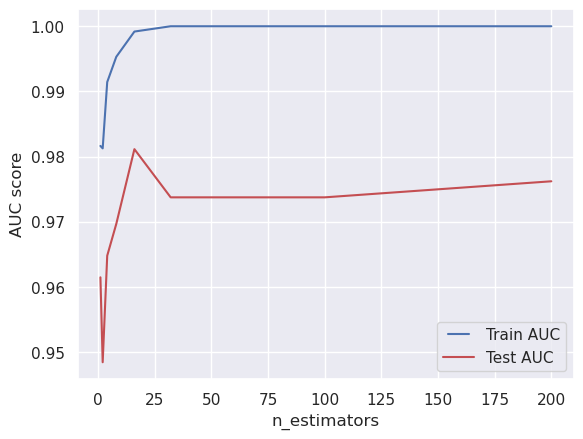

In [26]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=64, max_depth=5, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)   
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)


from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
clf_logistics = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr', max_iter=620).fit(X_train, y_train)
train_test_model(clf_logistics, "LR")

Before PCA for  LR
CV Score:  0.9705974727027359
Train accuracy:  0.9719887955182073
Time Taken to Train is 0.0009236335754394531 seconds 
Test accuracy:   0.9719101123595506
Time Taken to Test is 0.0007994174957275391 seconds 
              precision    recall  f1-score   support

           0    0.98010   0.97044   0.97525       203
           1    0.96129   0.97386   0.96753       153

    accuracy                        0.97191       356
   macro avg    0.97069   0.97215   0.97139       356
weighted avg    0.97202   0.97191   0.97193       356




After PCA for  LR
CV Score:  0.9719911667280089
Train accuracy:  0.9733893557422969
Time Taken to Train is 0.0009279251098632812 seconds 
Test accuracy:   0.9662921348314607
Time Taken to Test is 0.0007996559143066406 seconds 


### Plotting Accuracy for each model

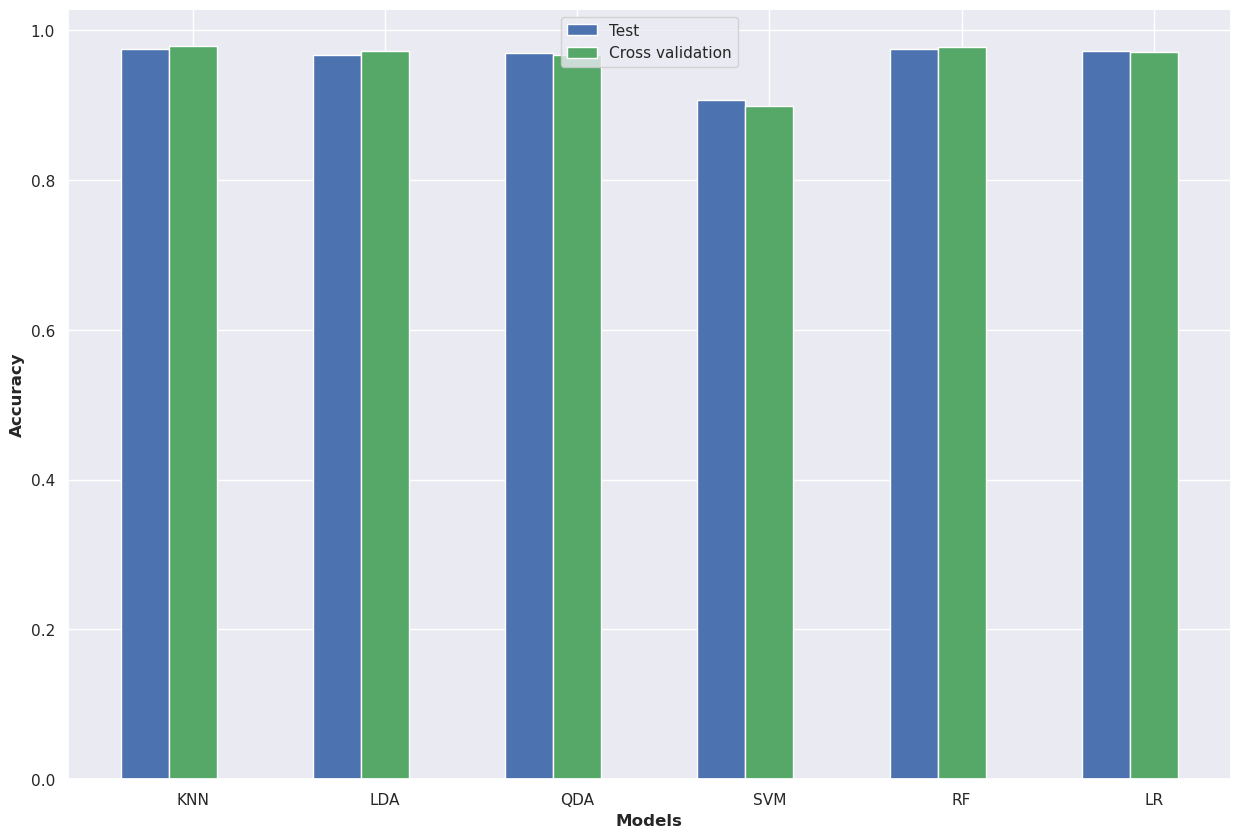

In [28]:
# %matplotlib notebook
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(accuracy_test))
r2 = [x + barWidth for x in r1]

plt.figure(figsize = (15,10))

# Make the plot
plt.bar(r1, accuracy_test, color='b', width=barWidth, edgecolor='white', label='Test')
plt.bar(r2, cross_validation, color='g', width=barWidth, edgecolor='white', label='Cross validation')
 
# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(accuracy_test))], ['KNN', 'LDA', 'QDA', 'SVM', 'RF', 'LR'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

### Before PCA & After PCA Curve

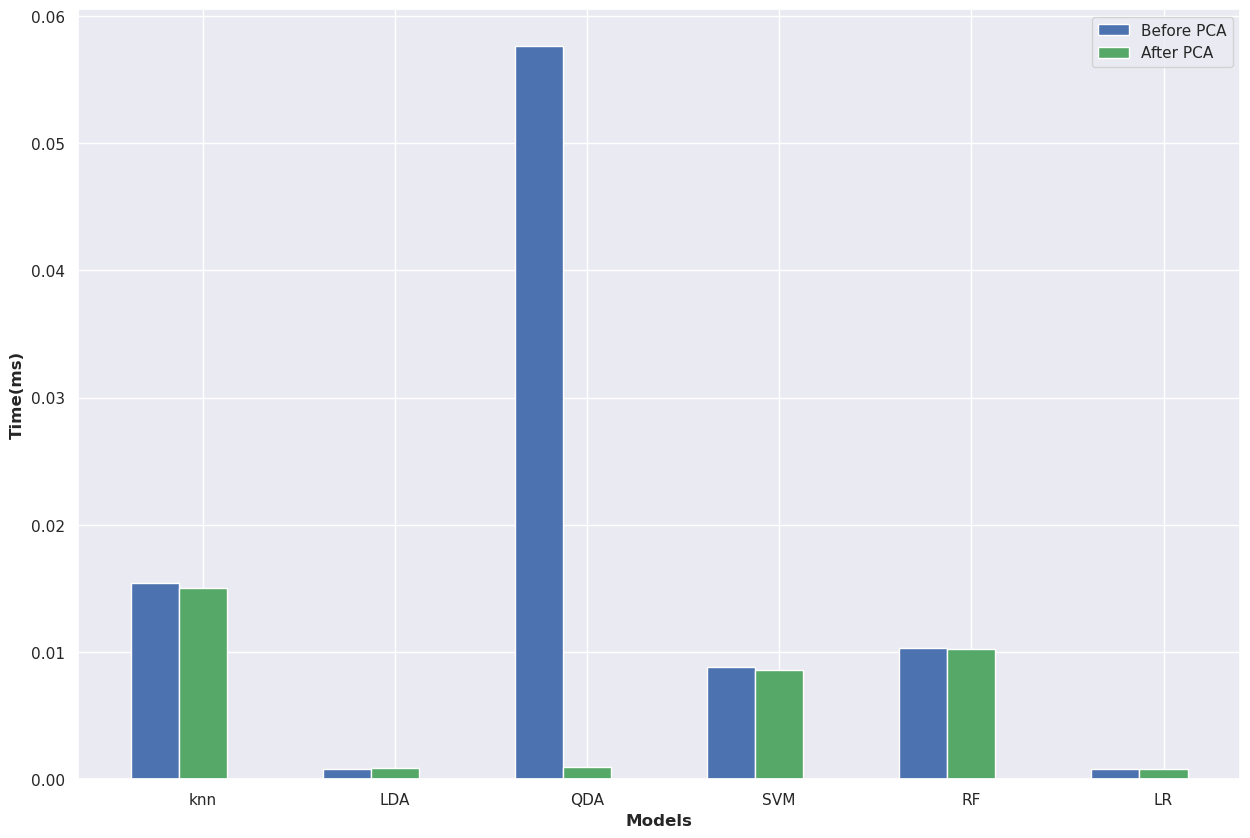

In [29]:
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(time_regular))
r2 = [x + barWidth for x in r1]

plt.figure(figsize = (15,10))

# Make the plot
plt.bar(r1, time_regular, color='b', width=barWidth, edgecolor='white', label='Before PCA')
plt.bar(r2, time_PCA, color='g', width=barWidth, edgecolor='white', label='After PCA')
# plt.bar(r3, cross_validation, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
 
# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Time(ms)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(time_regular))], ['knn', 'LDA', 'QDA', 'SVM', 'RF', 'LR'])
 
# Create legend & Show graphic
plt.legend()
plt.show()